# VC - Entrega P2

In [9]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [2]:
img = cv2.imread('mandril.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gris, 100, 200)

### 1 - Contar los bordes por filas y mostrar las filas con bordes por el encima de 90% del máximo

(0.0, 512.0)

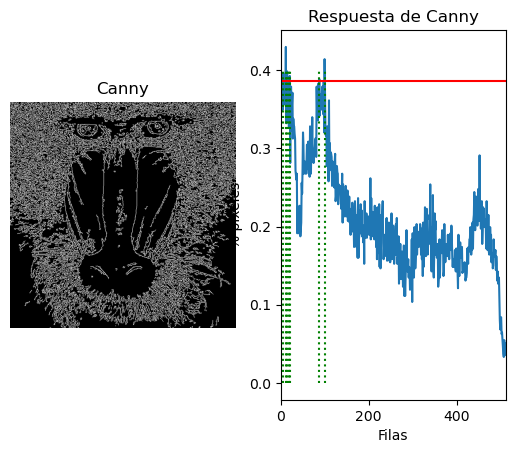

In [3]:
borders_by_row_sum = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
borders_by_row_ratio = borders_by_row_sum[:, 0] / (255 * canny.shape[1])
rows_over_threshold = np.where(borders_by_row_ratio > 0.9 * np.max(borders_by_row_ratio))[0]

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(borders_by_row_ratio)
plt.axhline(y=np.max(borders_by_row_ratio)*0.9, color='r')

plt.vlines(x=rows_over_threshold, ymin=0, ymax=0.4, color='g', linestyle=':', label='Rows over threshold')
plt.xlim([0, canny.shape[0]])



2. TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

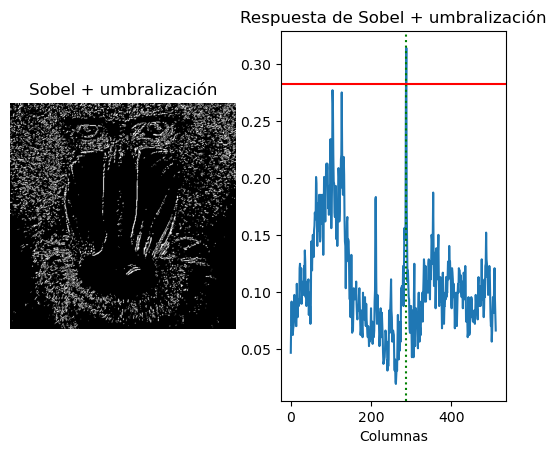

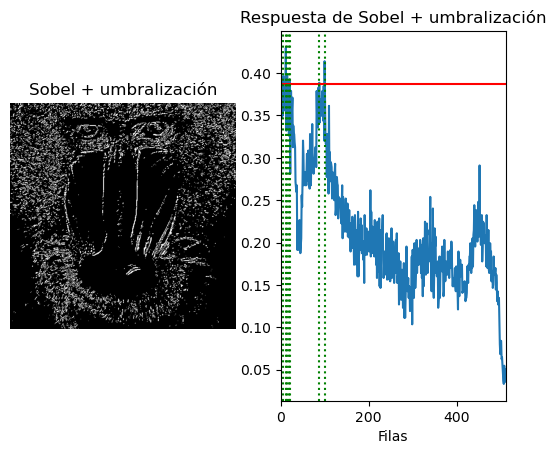

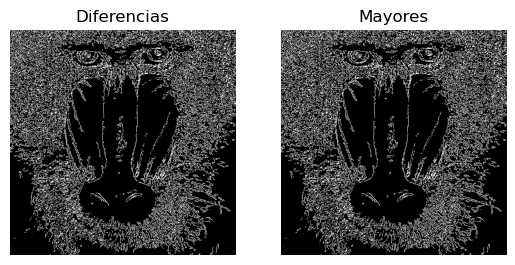

In [12]:
#Calcula en ambas direcciones (horizontal y vertical)
# Gaussiana para suavizar la imagen original, eliminando altas frecuencias
ggris = cv2.GaussianBlur(gris, (3, 3), 0)

sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)  # x
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)  # y

#Combina ambos resultados
sobel = cv2.add(sobelx, sobely)
sobel8np = np.uint8(np.abs(sobel))


#Umbralizamos la imagen de 8 bits del mandril

valorUmbral = 130
_, imagenUmbralizada8np = cv2.threshold(sobel8np, valorUmbral, 255, cv2.THRESH_BINARY)

#Conteo en columnas

col_counts = cv2.reduce(imagenUmbralizada8np,0,cv2.REDUCE_SUM,dtype=cv2.CV_32SC1)
cols = col_counts[0]/(255*imagenUmbralizada8np.shape[0])
max_border_number = max(cols)

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Sobel + umbralización")
plt.imshow(imagenUmbralizada8np, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Respuesta de Sobel + umbralización")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(cols)
for i in range(len(cols)):
    if cols[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')
plt.axhline(y=max_border_number*0.9, color='r')



# Lo mismo se ha realizado para las filas
row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows =[row_counts[i][0] / (255 * canny.shape[1]) for i in range(canny.shape[0])]
max_border_number = max(rows)

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Sobel + umbralización")
plt.imshow(imagenUmbralizada8np, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Respuesta de Sobel + umbralización")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(rows)
plt.axhline(y=max_border_number*0.9, color='r')
for i in range(len(rows)):
    if rows[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')
plt.xlim([0, imagenUmbralizada8np.shape[0]])


dif = cv2.absdiff(canny,imagenUmbralizada8np)
#Visualiza
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Diferencias")
plt.axis("off")
plt.imshow(dif, cmap='gray')


#Zonas de mayor diferencia tras aplicar umbral
res, imgdif = cv2.threshold(dif, 160, 255, cv2.THRESH_BINARY)

#Visualiza
plt.subplot(1, 2, 2)
plt.title("Mayores")
plt.axis("off")
plt.imshow(imgdif, cmap='gray')
plt.show() 

3. TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.

In [18]:
from abc import ABC, abstractmethod

class CameraFilter(ABC):
    def __init__(self, width, height):
        self.width = width
        self.height = height

    @abstractmethod
    def apply_to_image(self, current_frame):
        pass

class CannyCameraFilter(CameraFilter):
    def __init__(self, width, height, threshold1=100, threshold2=200):
        super().__init__(width, height)
        self.threshold1 = threshold1
        self.threshold2 = threshold2

    def apply_to_image(self, current_frame):
        gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_frame, self.threshold1, self.threshold2)
        edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        return edges_bgr
    
class NoCameraFilter(CameraFilter):
    def __init__(self, width, height):
        super().__init__(width, height)

    def apply_to_image(self, current_frame):
        return current_frame

class MinecraftCameraFilter(CameraFilter):
    texture_directory = "textures/"
    EMPTY_LOOKUP = 255

    minecraft_block_size = 16
    minecraft_block_textures = []
    minecraft_block_colors = []
    # Pequeña optimización a coste de 16MB de memoria. Se guardan los colores ya computados
    lookup_table = np.full((256,256,256), EMPTY_LOOKUP, dtype=np.uint8)
    def __init__(self, width, height, filter_rows, filter_columns):
        super().__init__(width, height)
        self.rows = filter_rows
        self.columns = filter_columns
        self.buffer = np.zeros((self.height, self.width, 3), dtype=np.uint8)

    @staticmethod
    def average_color(img):
        return np.array(np.mean(img, axis=(0,1)).astype(int))

    @staticmethod
    def load_textures():
        # Cargar texturas y clasificarlas según su color más prominente
        for filename in os.listdir(MinecraftCameraFilter.texture_directory):
            if filename.endswith(".png"):
                texture_img = cv2.imread(MinecraftCameraFilter.texture_directory + filename)
                MinecraftCameraFilter.minecraft_block_textures.append(texture_img)
                MinecraftCameraFilter.minecraft_block_colors.append(MinecraftCameraFilter.average_color(texture_img))

    # Se calcula el color de la textura más parecida
    @staticmethod
    def find_nearest_texture(color):
        r, g, b = color
        if MinecraftCameraFilter.lookup_table[r][g][b] != MinecraftCameraFilter.EMPTY_LOOKUP:
            return MinecraftCameraFilter.minecraft_block_textures[MinecraftCameraFilter.lookup_table[r][g][b]]

        distances = np.linalg.norm(MinecraftCameraFilter.minecraft_block_colors - np.array([r, g, b]), axis=1)
        best_match_index = np.argmin(distances)

        MinecraftCameraFilter.lookup_table[r][g][b] = best_match_index
        return MinecraftCameraFilter.minecraft_block_textures[best_match_index]

    def apply_to_image(self, current_frame):
        downscaled_img = cv2.resize(current_frame, (self.columns, self.rows), interpolation=cv2.INTER_NEAREST)
        for x in range(self.rows):
            for y in range(self.columns):
                # Optimización de x * 16
                minecraft_x = x << 4
                minecraft_y = y << 4
                self.buffer[minecraft_x:minecraft_x + MinecraftCameraFilter.minecraft_block_size, minecraft_y:minecraft_y + MinecraftCameraFilter.minecraft_block_size] = MinecraftCameraFilter.find_nearest_texture(downscaled_img[x][y])
        return self.buffer

MinecraftCameraFilter.load_textures()



Se coge la entrada de la cámara, se divide entre el tamaño de las texturas y se reemplaza cada pixel por el bloque que más se le parezca

In [19]:
vid = cv2.VideoCapture(0)
is_camera_working, camera_feed = vid.read()

minecraft_rows, minecraft_columns = 0, 0
h, w = 0, 0

# Se guardan las dimensiones y se calcula el redimensionado
if is_camera_working:
    h, w, c = camera_feed.shape
    minecraft_rows = int(h/MinecraftCameraFilter.minecraft_block_size)
    minecraft_columns = int(w/MinecraftCameraFilter.minecraft_block_size)

available_filters = [
    NoCameraFilter(w, h),
    MinecraftCameraFilter(w, h, minecraft_rows, minecraft_columns),
    CannyCameraFilter(w, h, threshold1=100, threshold2=200)
]

current_filter = 0

while is_camera_working:
    cv2.imshow('VC DEMO', available_filters[current_filter].apply_to_image(camera_feed))
    is_camera_working, camera_feed = vid.read()

    key = cv2.waitKey(20)
    if key & 0xFF == ord('d'):
        current_filter = (current_filter + 1) % len(available_filters)
    elif key & 0xFF == ord('a'):
        current_filter = (current_filter - 1) % len(available_filters)
    elif key == 27:
        break


vid.release()
cv2.destroyAllWindows()

TAREA: Tras ver los vídeos [My little piece of privacy](https://www.niklasroy.com/project/88/my-little-piece-of-privacy), [Messa di voce](https://youtu.be/GfoqiyB1ndE?feature=shared) y [Virtual air guitar](https://youtu.be/FIAmyoEpV5c?feature=shared) proponer un demostrador reinterpretando la parte de procesamiento de la imagen, tomando como punto de partida alguna de dichas instalaciones.

In [ ]:


import cv2
import numpy as np


lower_blue = np.array([100, 80, 50])
upper_blue = np.array([125, 255, 255]) 
MIN_AREA = 3000
PADDING = 15 


COLOR_DERECHA = (0, 255, 255)    
COLOR_IZQUIERDA = (0, 165, 255) 
COLOR_SIMPLE = (255, 255, 0)     


# PASO 1: Cargar y preparar la imagen del pico

try:
    pico_img = cv2.imread('./output_image/pico_minecraft.png', cv2.IMREAD_UNCHANGED)
    if pico_img is None:
        raise FileNotFoundError
except FileNotFoundError:
    print("ERROR: No se pudo cargar 'pico_minecraft.png'. Asegúrate de que está en el directorio.")
    # Si falla la carga, sigue como línea simple para evitar un crash
    pico_img = None

# Establecer un tamaño de referencia para el pico
PICO_ALTURA_ESTANDAR = 100 

if pico_img is not None:
    # Redimensionar el pico a un tamaño manejable (ej. 100 píxeles de alto)
    aspect_ratio = pico_img.shape[1] / pico_img.shape[0]
    pico_w = int(PICO_ALTURA_ESTANDAR * aspect_ratio)
    pico_img = cv2.resize(pico_img, (pico_w, PICO_ALTURA_ESTANDAR), interpolation=cv2.INTER_AREA)
    
    # Separar el canal alfa (transparencia) si existe
    if pico_img.shape[2] == 4:
        pico_bgr = pico_img[:, :, :3] # BGR
        pico_alpha = pico_img[:, :, 3] # Alfa
        # Crear máscara binaria a partir del canal alfa
        pico_mask = pico_alpha
    else:
        # Si no hay canal alfa, crea una máscara simple (todo sólido)
        pico_bgr = pico_img
        pico_mask = np.ones(pico_bgr.shape[:2], dtype=np.uint8) * 255

# Función auxiliar para rotar una imagen
def rotate_image(image, angle, center=None, scale=1.0):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated, M

# Función auxiliar para incrustar una imagen
def overlay_image(background, overlay, mask, x_offset, y_offset):
    # Obtener dimensiones
    h, w = overlay.shape[:2]
    h_bg, w_bg = background.shape[:2]
    
    # Coordenadas de la región de interés (ROI) en el fondo
    y1, y2 = max(0, y_offset), min(h_bg, y_offset + h)
    x1, x2 = max(0, x_offset), min(w_bg, x_offset + w)
    
    # Coordenadas de la región de interés (ROI) en la imagen superpuesta
    y1_ov = y1 - y_offset
    y2_ov = y2 - y_offset
    x1_ov = x1 - x_offset
    x2_ov = x2 - x_offset
    
    # Si la región es válida
    if y2 > y1 and x2 > x1:
        roi = background[y1:y2, x1:x2]
        overlay_roi = overlay[y1_ov:y2_ov, x1_ov:x2_ov]
        mask_roi = mask[y1_ov:y2_ov, x1_ov:x2_ov]
        
        # Invertir la máscara (la región donde NO va la imagen)
        mask_inv = cv2.bitwise_not(mask_roi)
        
        # Eliminar la región donde se colocará el pico del fondo
        bg_masked = cv2.bitwise_and(roi, roi, mask=mask_inv)
        
        # Extraer el pico de su fondo
        fg_masked = cv2.bitwise_and(overlay_roi, overlay_roi, mask=mask_roi)
        
        # Combinar el fondo sin la región y el pico
        final_roi = cv2.add(bg_masked, fg_masked)
        
        # Poner el resultado final de vuelta en el frame
        background[y1:y2, x1:x2] = final_roi
    
    return background



vid = cv2.VideoCapture(0)

while True:
    is_camera_working, frame = vid.read()
    if not is_camera_working:
        break
        
    frame = cv2.flip(frame, 1) # Voltear para vista de espejo
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # 1. Crear Máscara y Morfología
    mask = cv2.inRange(hsv, lower_blue, upper_blue)
    kernel = np.ones((7, 7), np.uint8) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # 2. Encontrar Contornos
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    guantes_data = []
    
    # Filtrar, ordenar por tamaño y tomar los dos más grandes
    valid_contours = [c for c in contours if cv2.contourArea(c) > MIN_AREA]
    valid_contours.sort(key=cv2.contourArea, reverse=True)
    
    # 3. Procesar Contornos Válidos
    for contour in valid_contours[:2]: 
        x, y, w, h = cv2.boundingRect(contour)
        cx, cy = x + w // 2, y + h // 2
        
        # Almacenar los datos del guante (centro, contorno, caja)
        guantes_data.append(((cx, cy), contour, (x, y, w, h)))
        
        # Dibujar solo el centro 
        cv2.circle(frame, (cx, cy), 5, (255, 0, 0), -1) # Círculo de centro azul


    # 4. Lógica de Dibujo (Una o Dos Manos)
    
    if len(guantes_data) == 2:
        
        # Dos Manos: Asignar Lados, Dibujar Rectángulos Rotados y PICO
        
        guantes_data.sort(key=lambda item: item[0][0]) 
        
        for i, data in enumerate(guantes_data):
            p_centro, contour, p_rect = data
            x, y, w, h = p_rect
            
            # Obtener el Rectángulo Mínimo Rotado
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            # Asignación de lado y color
            if i == 0: 
                lado, color = 'Mano DERECHA', COLOR_DERECHA
            else: 
                lado, color = 'Mano IZQUIERDA', COLOR_IZQUIERDA
                
            # Dibujar el rectángulo ROTADO
            cv2.drawContours(frame, [box], 0, color, 2) 

            # Dibujar el texto
            x_text = x - PADDING
            y_text = y - PADDING
            cv2.putText(frame, lado, (x_text, y_text - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        
        
        # PASO 2: Reemplazar cv2.line() por el pico
        
        if pico_img is not None:
            # Obtener los puntos centrales
            p1_centro = guantes_data[0][0] # Izquierda
            p2_centro = guantes_data[1][0] # Derecha
            x1, y1 = p1_centro
            x2, y2 = p2_centro
            
            # Calcular la longitud de la línea (distancia)
            distancia = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            
            # 1. Redimensionar el pico para que su longitud coincida con la distancia entre los guantes
            pico_img_resized = cv2.resize(pico_bgr, (int(distancia), PICO_ALTURA_ESTANDAR), interpolation=cv2.INTER_AREA)
            pico_mask_resized = cv2.resize(pico_mask, (int(distancia), PICO_ALTURA_ESTANDAR), interpolation=cv2.INTER_NEAREST)

            # 2. Calcular el ángulo de rotación (en grados)
            angle_rad = np.arctan2(y2 - y1, x2 - x1)
            angle_deg = np.degrees(angle_rad)
            
            # 3. Rotar el pico
            pico_rotated, M = rotate_image(pico_img_resized, angle_deg, center=(0, PICO_ALTURA_ESTANDAR // 2))
            mask_rotated, _ = rotate_image(pico_mask_resized, angle_deg, center=(0, PICO_ALTURA_ESTANDAR // 2))

            # 4. Calcular la posición (esquina superior izquierda) para el incruste
            
            x_offset = x1 
            y_offset = y1 - (pico_rotated.shape[0] // 2) # Centrar verticalmente en y1
            
            # 5. Incrustar la imagen rotada en el frame
            frame = overlay_image(frame, pico_rotated, mask_rotated, x_offset, y_offset)

        else:
             # Si el pico no se carga, traza la línea original (opcional, para debug)
             cv2.line(frame, guantes_data[0][0], guantes_data[1][0], COLOR_DERECHA, 5) 
            
    elif len(guantes_data) == 1:
        
        # Una Sola Mano
        p_centro, contour, p_rect = guantes_data[0]
        x, y, w, h = p_rect
        
        # Obtener el Rectángulo Mínimo Rotado
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Dibujar el rectángulo ROTADO 
        cv2.drawContours(frame, [box], 0, COLOR_SIMPLE, 2) 

        # Dibujar el texto neutro
        x_text = x - PADDING
        y_text = y - PADDING
        cv2.putText(frame, 'Guante Azul', (x_text, y_text - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, COLOR_SIMPLE, 2)


    cv2.imshow('Deteccion de Guantes Azules y Pico', frame)
    
    key = cv2.waitKey(20)
    if key == 27: # Presiona ESC para salir
        break

vid.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def canny_detect_shapes_by_rows(canny_img, threshold=0.9):
    borders_by_row_sum = cv2.reduce(canny_img, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
    borders_by_row_ratio = borders_by_row_sum[:, 0] / (255 * canny_img.shape[1])
    return borders_by_row_ratio, np.where(borders_by_row_ratio > threshold * np.max(borders_by_row_ratio))[0]

def canny_detect_shapes_by_columns(canny_img, threshold=0.9):
    borders_by_column_sum = cv2.reduce(canny_img, 0, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
    borders_by_column_ratio = borders_by_column_sum[0] / (255 * canny_img.shape[0])
    return borders_by_column_ratio, np.where(borders_by_column_ratio > threshold * np.max(borders_by_column_ratio))[0]



fig, axes = plt.subplots(1, 2, figsize=(10, 4))

line_row, = axes[0].plot([], [])
axes[0].set_title("Bordes por filas")
axes[0].set_xlabel("Filas")
axes[0].set_ylabel("% píxeles")

line_col, = axes[1].plot([], [])
axes[1].set_title("Bordes por columnas")
axes[1].set_xlabel("Columnas")
axes[1].set_ylabel("% píxeles")

plt.tight_layout()

prev_col_max, prev_row_max = 0.4, 0.4

vid = cv2.VideoCapture(0)
is_camera_working, camera_feed = vid.read()
max_points_row = []
max_points_column = []

while is_camera_working:
    is_camera_working, camera_feed = vid.read()
        # Clear previous lines
    for line in max_points_row:
        line.remove()
    max_points_row.clear()

    for line in max_points_column:
        line.remove()
    max_points_column.clear()

    camera_hsv = cv2.cvtColor(camera_feed, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(camera_hsv, (0, 120, 70), (10, 255, 255)) + cv2.inRange(camera_hsv, (170, 120, 70), (180, 255, 255))
    camera_masked = cv2.bitwise_and(camera_feed, camera_feed, mask=mask)


    canny_img = cv2.Canny(camera_masked, 100, 200)
    # Get border ratio data
    rows_data, max_rows = canny_detect_shapes_by_rows(canny_img)
    cols_data, max_columns = canny_detect_shapes_by_columns(canny_img)


    # Update plots
    line_row.set_data(np.arange(len(rows_data)), rows_data)
    line_col.set_data(np.arange(len(cols_data)), cols_data)

    axes[0].set_xlim(0, len(rows_data))
    axes[0].set_ylim(0, prev_row_max)

    for row in max_rows:
        line = axes[0].axvline(x=row, color='red', linestyle='--', linewidth=1)
        max_points_row.append(line)
    
    axes[1].set_xlim(0, len(cols_data))
    axes[1].set_ylim(0, prev_col_max)
    for col in max_columns:
        line = axes[1].axvline(x=col, color='blue', linestyle='--', linewidth=1)
        max_points_column.append(line)

    fig.canvas.draw()
    fig.canvas.flush_events()

    cv2.imshow('Inspiring', camera_masked)
    key = cv2.waitKey(20)
    if key == 27:
        break


vid.release()
cv2.destroyAllWindows()
"""